In [1]:
nome = 'Arthur Baia'
print(f'Meu nome é {nome}')

Meu nome é Arthur Baia


#  Exercício: Modelo de Linguagem (Bengio 2003) - MLP + Embeddings

Neste exercício iremos treinar uma rede neural similar a do Bengio 2003 para prever a próxima palavra de um texto, data as palavras anteriores como entrada. Esta tarefa é chamada de "Modelagem da Linguagem".

Algumas dicas:
- Inclua caracteres de pontuação (ex: `.` e `,`) no vocabulário.
- Deixe tudo como caixa baixa (lower-case).
- A escolha do tamanho do vocabulario é importante: ser for muito grande, fica difícil para o modelo aprender boas representações. Se for muito pequeno, o modelo apenas conseguirá gerar textos simples.
- Remova qualquer exemplo de treino/validação/teste que tenha pelo menos um token desconhecido (ou na entrada ou na saída). 
- Este dataset já possui um tamanho razoável e é bem provável que você vai precisar rodar seus experimentos com GPU.
- Durante a depuração, faça seu dataset ficar bem pequeno, para que a depuração seja mais rápida e não precise de GPU. Somente ligue a GPU quando o seu laço de treinamento já está funcionando
- Não deixe para fazer esse exercício na véspera. Ele é trabalhoso.

## Importação dos pacotes

In [2]:
import collections
import itertools
import functools
import math
import os
import random
import re

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook
from typing import List

In [3]:
# Check which GPU we are using
!nvidia-smi

Sun Sep 18 11:05:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P5    11W /  N/A |    615MiB /  5944MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Carregamento do dataset 

Primeiro, fazemos download do dataset:

In [5]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

File ‘aclImdb.tgz’ already there; not retrieving.



## Carregando o dataset

Criaremos uma divisão de treino (80%) e validação (20%) artificialmente.

Nota: Evitar de olhar ao máximo o dataset de teste para não ficar enviseado no que será testado. Em aplicações reais, o dataset de teste só estará disponível no futuro, ou seja, é quando o usuário começa a testar o seu produto.

In [6]:
def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg

# Embaralhamos o treino para depois fazermos a divisão treino/valid.
random.shuffle(x_train)

n_train = int(0.8 * len(x_train))

x_valid = x_train[n_train:]
x_train = x_train[:n_train]

print(len(x_train), 'amostras de treino.')
print(len(x_valid), 'amostras de desenvolvimento.')
print(len(x_test), 'amostras de teste.')

print('3 primeiras amostras treino:')
for x in x_train[:3]:
    print(x[:100])

print('3 últimas amostras treino:')
for x in x_train[-3:]:
    print(x[:100])

print('3 primeiras amostras validação:')
for x in x_valid[:3]:
    print(x[:100])

print('3 últimas amostras validação:')
for x in x_valid[-3:]:
    print(x[:100])

20000 amostras de treino.
5000 amostras de desenvolvimento.
25000 amostras de teste.
3 primeiras amostras treino:
Really, I can't believe that I spent $5 on this movie. I am a huge zombie fanatic and thought the mo
You know a movie will not go well when John Carradine narrates (a.k.a. reads the script & plot synop
I must give How She Move a near-perfect rating because the content is truly great. As a previous rev
3 últimas amostras treino:
I don't know if I'm just weird, but I thoroughly enjoyed this film. <br /><br />Return to Cabin by t
I recently got the chance to view "The Waterdance", and quite liked it. I don't really understand wh
As it is in Heaven {SPOILER WARNING)<br /><br />This was a great human drama that stimulated my emot
3 primeiras amostras validação:
I don't believe this was an acting challenge for Richard Harris. This was an uncomplicated plot, yet
Wow, I loved this film. It may not have had the funding and advertising that the latest hollywood bl
After viewing the f

### Tokenizer

In [7]:
unk = '<UNK>'

In [10]:
class Tokenizer():

    def __init__(self, max_vocab_token=1000):

        self.max_vocab_tokens = max_vocab_token

    def encode(self, text: str):
        # Escreva aqui seu código.
        return [self.vocab[word] if word in self.vocab else unk for word in self.tokenize(text)]

    def decode(self, tokens: List[int]):
        # Escreva aqui seu código.
        return ' '.join([self.vocab_inv[token] for token in tokens])

    def create_vocab(self, texts: List[str]):
        L = [word for phrase in list(map(self.tokenize, texts))
             for word in phrase]
        k = self.max_vocab_tokens
        def vocab(L, k): return {value: key for key, value in enumerate(
            dict(collections.Counter(L).most_common(k)))}
        self.vocab = vocab(L, k)
        self.vocab_inv = {v: k for k, v in self.vocab.items()}
    def tokenize(self, text: str):
        """
        Convert string to a list of tokens (i.e., words).
        This function lower cases everything and removes punctuation.
        """
        # Escreva aqui seu código.
        return re.findall(r"\w+|[^\w\s]", text.lower())


In [15]:
def test_tokenizer():
    phrase = 'a cat walks in the bad.'
    vocab = Tokenizer(len(phrase.split())+1)
    vocab_ = vocab.create_vocab([phrase])
    print(vocab.encode(phrase))
    print(vocab.decode(vocab.encode(phrase)))
    # assert vocab.decode(vocab.encode(phrase)) == phrase
    print(vocab.decode(vocab.encode('a cat walks.')))
test_tokenizer()


[0, 1, 2, 3, 4, 5, 6]
a cat walks in the bad .
a cat walks .


## Dataset

In [106]:
class IMDBdataset(torch.utils.data.Dataset):
    def __init__(self, corpus: List[str], vocab, context_size=9):
        data = []
        for text in corpus:
            tokens = vocab.encode(text)
            data.extend([
                tokens[i:i+context_size+1] for i in range(len(tokens)-context_size)
                if unk not in tokens[i:i+context_size+1] and len(tokens) > context_size
            ])
        self.data = torch.tensor(data)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx][:-1], self.data[idx][-1].long()


In [107]:
"""Function to test the dataset"""
def test_dataset():
    vocab = Tokenizer()
    test_corpus = ['a cat walks in the bad.', 'a dog walks in the good.']
    vocab.create_vocab(test_corpus)
    unseen_tokens = ['aprendendo sobre o modelo n-grama']
    dataset_ = IMDBdataset(unseen_tokens, vocab, 3)
    assert len(dataset_) == 0
    context_size = 3
    dataset_ = IMDBdataset(test_corpus, vocab, context_size=context_size)
    assert len(dataset_) == 8
    assert len(dataset_.__getitem__(0)[0].tolist()) == context_size
    assert len([dataset_.__getitem__(0)[1].tolist()]) == 1
    assert dataset_.__getitem__(0)[1].tolist() == vocab.encode('in')[0]
    assert dataset_.__getitem__(0)[0].tolist() == vocab.encode('a cat walks')


test_dataset()

## Dataloader

In [108]:
"""function to test the dataloader"""
def test_dataloader():
    vocab = Tokenizer()
    test_corpus = ['a cat walks in the bad.', 'a dog walks in the good.']
    vocab.create_vocab(test_corpus)
    context_size = 3
    dataset_ = IMDBdataset(test_corpus, vocab, context_size=context_size)
    dataloader_ = torch.utils.data.DataLoader(dataset_, batch_size=2, shuffle=True)
    for batch in dataloader_:
        assert len(batch[0].shape) == 2
        assert len(batch[1].shape) == 1
        assert batch[0].shape[0] == batch[1].shape[0]
        assert batch[0].shape[1] == context_size
        break
test_dataloader()

## Model

In [109]:
class BengioModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, context_size):
        super(BengioModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size*embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        return torch.log_softmax(x, dim=1)


In [110]:
"""Function to test the model"""
def test_model():
    vocab = Tokenizer()
    test_corpus = ['a cat walks in the bad.', 'a dog walks in the good.']
    vocab.create_vocab(test_corpus)
    context_size = 3
    dataset_ = IMDBdataset(test_corpus, vocab, context_size=context_size)
    dataloader_ = torch.utils.data.DataLoader(dataset_, batch_size=2, shuffle=True)
    model = BengioModel(len(vocab.vocab), 10, 10, context_size)
    for batch in dataloader_:
        output = model(batch[0])
        assert output.shape == (dataloader_.batch_size, len(vocab.vocab))
        break
test_model()

## Train and evaluate

In [111]:
"""Function to train the model, which returns the train loss"""
def train(model, train_dataloader, loss_func, optimizer):
    model.train()
    train_loss = 0
    for x,y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_dataloader)

In [113]:
"""Function to evaluate the model, which returns the validation loss and accuracy"""
def evaluate(model, num_examples, valid_dataloader, loss_func):

    correct = 0
    val_loss = 0

    for x, y in valid_dataloader:
        x, y = x.to(device), y.to(device)

        with torch.no_grad():

          logits = model(x)

        preds = logits.argmax(dim=1)

        loss = loss_func(logits, y)

        val_loss += loss.item()

        correct += (preds==y).sum().item()

    return (correct / num_examples), (val_loss / len(valid_dataloader))

In [114]:
"""Function to test the training and evaluation functions"""
def test_train_eval():
    vocab = Tokenizer()
    test_corpus = ['a cat walks in the bad.', 'a dog walks in the good.']
    vocab.create_vocab(test_corpus)
    context_size = 3
    dataset_ = IMDBdataset(test_corpus, vocab, context_size=context_size)
    dataloader_ = torch.utils.data.DataLoader(dataset_, batch_size=2, shuffle=True)
    model = BengioModel(len(vocab.vocab), 10, 10, context_size)
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_loss = train(model, dataloader_, loss_func, optimizer)
    valid_loss, accuracy = evaluate(model, dataloader_, loss_func)
    assert train_loss > 0
    assert valid_loss > 0
    assert accuracy > 0

## Hyperparameters

In [125]:
learning_rate = 0.0001
vocab = Tokenizer()
vocab.create_vocab(x_train)
context_size = 5
dataset_train = IMDBdataset(x_train, vocab, context_size=context_size)
dataset_valid = IMDBdataset(x_valid, vocab, context_size=context_size)
num_examples = len(dataset_valid)
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
model = BengioModel(len(vocab.vocab), 100, 100, context_size)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)
loss_func.to(device)

CrossEntropyLoss()

In [126]:


epochs = 100
train_losses = []
valid_losses = []
accuracy_train = []
perplexities = []
accuracy, valid_loss = evaluate(model, num_examples,valid_dataloader, loss_func)
print(f"Pré treino; Validation Loss: {valid_loss:.3f}; Perplexity: {np.exp(valid_loss):.3f}; Accuracy: {accuracy:.3f}")
for t in range(epochs):
  train_loss = train(model, train_dataloader, loss_func, optimizer)
  train_losses.append(train_loss)
  accuracy, valid_loss = evaluate(model, num_examples, valid_dataloader, loss_func)
  valid_losses.append(valid_loss)
  accuracy_train.append(accuracy)
  perplexities.append(np.exp(train_loss))
  print(f"Epoch: {t+1}; Train Loss: {train_loss:.3f}; Perplexity: {np.exp(train_loss):.3f}; Validation Loss: {valid_loss:.3f}; Accuracy: {accuracy:.3f}")



Pré treino; Validation Loss: 6.899; Perplexity: 991.464; Accuracy: 0.001
Epoch: 1; Train Loss: 4.260; Perplexity: 70.795; Validation Loss: 3.991; Accuracy: 0.293
Epoch: 2; Train Loss: 3.906; Perplexity: 49.720; Validation Loss: 3.870; Accuracy: 0.310
Epoch: 3; Train Loss: 3.819; Perplexity: 45.569; Validation Loss: 3.815; Accuracy: 0.316
Epoch: 4; Train Loss: 3.772; Perplexity: 43.483; Validation Loss: 3.783; Accuracy: 0.321
Epoch: 5; Train Loss: 3.742; Perplexity: 42.176; Validation Loss: 3.760; Accuracy: 0.325
Epoch: 6; Train Loss: 3.720; Perplexity: 41.248; Validation Loss: 3.743; Accuracy: 0.328
Epoch: 7; Train Loss: 3.702; Perplexity: 40.538; Validation Loss: 3.731; Accuracy: 0.329
Epoch: 8; Train Loss: 3.688; Perplexity: 39.970; Validation Loss: 3.720; Accuracy: 0.331
Epoch: 9; Train Loss: 3.676; Perplexity: 39.505; Validation Loss: 3.712; Accuracy: 0.332
Epoch: 10; Train Loss: 3.666; Perplexity: 39.110; Validation Loss: 3.704; Accuracy: 0.333
Epoch: 11; Train Loss: 3.658; Perple

In [130]:
"""Use the test dataset to evaluate the model"""


dataset_test = IMDBdataset(x_test, vocab, context_size=context_size)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True)
acc, loss = evaluate(model, num_examples, test_dataloader, loss_func)
print(f"Test Loss: {loss:.3f}; Perplexity: {np.exp(loss):.3f}; Accuracy: {acc:.3f}")


Test Loss: 3.607; Perplexity: 36.869; Accuracy: 1.696


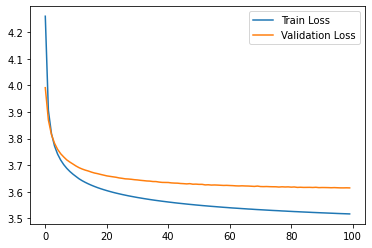

In [131]:
import matplotlib.pyplot as plt
"""Plot the training and validation losses"""
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.show()
